In [58]:
import os
import sys
import subprocess
import shutil
import pickle

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))
import Hyperbolic as hyp

# AP code

In [2]:
def find_component(node, connected_components):
    for i, component in enumerate(connected_components):
        if node in component:
            return i
    raise ValueError(f'Component for node {node} not found')

In [3]:
def cascade_remove_links(G):

    keep_going = True
    while keep_going:
        keep_going = False

        clusters_in_layers = [list(nx.connected_components(g)) for g in G]

        for i, g in enumerate(G):
            clusters_to_search = clusters_in_layers[:i] + clusters_in_layers[i + 1:]
            for edge in g.edges():
                if any(find_component(edge[0], clusters) != find_component(edge[1], clusters)
                       for clusters in clusters_to_search):
                    keep_going = True
                    g.remove_edge(*edge)
    
    return G

In [4]:
def articulation_points_multiplex(G):
    ap = set(nx.articulation_points(G[0]))
    return ap.union(*[nx.articulation_points(g) for g in G[1:]])

In [5]:
def max_comp(g):
    return max(nx.connected_components(g), key=len)

In [6]:
def remove_ap(G):
    G = cascade_remove_links(G)

    gcc = max_comp(G[0])
    gcc_size = len(gcc)

    for g in G:
        g.remove_nodes_from([n for n in g if n not in gcc])

    art_points = articulation_points_multiplex(G)

    for g in G:
        g.remove_nodes_from(art_points)

    return G, art_points, gcc_size

# Experiment

In [7]:
kbar = 4.
gamma = 3.
T = .4
N = 50000

In [74]:
def generate(N, kbar, gamma, T):
    seed = 0xC0FFEE
    np.random.seed(seed)

    kmin = hyp.CalculateKmin(kbar, gamma)
    print('kmin: ', kmin)

    C = hyp.CalculateC(kbar, T, gamma)
    print('C: ', C)

    R = hyp.CalculateR(N, C)
    print('R: ', R)

    kappa = hyp.SampleKappa(N, kmin, gamma)
    theta = hyp.SampleTheta(N)

    r = hyp.ChangeVariablesFromS1ToH2(N, kappa[:], R, kmin)

    hyp.PrintCoordinates(r[:], theta[:], kappa[:], 'coords.txt')

    subprocess.call(['hyperb.exe', 'coords.txt', str(seed), str(N), str(kbar), str(T)])
    links = hyp.ReadLinks('links.coords.txt')
    return nx.Graph(links), np.array(r), np.array(theta)

In [75]:
def generate_real(path):
    datapath = '../../real_data_experiments/multiplex_embeddings_data'
    datapath = os.path.join(datapath, path)
    shutil.copyfile(datapath, 'network.txt')
    subprocess.call(['HyperMapWin.exe'])
    coords = np.array(hyp.ReadCoordinates('coordinates_embedding.txt'))
    return nx.read_edgelist(datapath), coords[:, 2], coords[:, 1]

In [76]:
def xi_in_ap_removal(N, kbar, gamma, T):
    G, _, theta = generate(N, kbar, gamma, T)
    xi = []
    gcc_lens = []
    while True:
        gcc = max_comp(G)
        G.remove_nodes_from([n for n in G if n not in gcc])
        xi.append(abs(np.exp(1j * theta[list(gcc)]).sum()) / len(gcc))
        gcc_lens.append(len(gcc))
        art_points = list(nx.articulation_points(G))
        G.remove_nodes_from(art_points)
        if not art_points:
            break
    return xi, gcc_lens

In [77]:
plt.rc('text', usetex=True)
plt.rc('font', size=30, **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['savefig.bbox'] = 'tight'
%matplotlib inline

colors = [
    '#1abc9c',  # turquoise
    '#9b59b6',  # amethyst
    '#34495e',  # wet asphalt
    '#2980b9',  # belize hole
    '#f1c40f',  # sun flower
    '#e74c3c',  # alizarin
    '#7f8c8d',  # asbestos
]

In [84]:
xi_curves = {}
gcc_stats = {}

# kbars = [.1] + list(range(1, 13))
# kbars = [.1] + list(range(2, 11, 2))

kbars = [2., 5., 6., 6.25, 6.5, 6.75, 7., 7.25, 7.5, 8., 12]

for kbar in kbars:
    xi, gcc_lens = xi_in_ap_removal(N, kbar, gamma, T)
    xi_curves[kbar] = xi
    gcc_stats[kbar] = gcc_lens

kmin:  1.0
C:  0.5944103226844709
R:  22.679927407155276
number of links:	 48942
kmin:  2.5
C:  1.4860258067111771
R:  20.847345943406964
number of links:	 122292
kmin:  3.0
C:  1.7832309680534126
R:  20.482702829819054
number of links:	 146779
kmin:  3.125
C:  1.8575322583889715
R:  20.401058840778546
number of links:	 152842
kmin:  3.25
C:  1.9318335487245304
R:  20.32261741447198
number of links:	 158933
kmin:  3.375
C:  2.0061348390600893
R:  20.24713675850629
number of links:	 165018
kmin:  3.5
C:  2.080436129395648
R:  20.17440147016454
number of links:	 171092
kmin:  3.625
C:  2.154737419731207
R:  20.104218830542
number of links:	 177236
kmin:  3.75
C:  2.229038710066766
R:  20.036415727190636
number of links:	 183389
kmin:  4.0
C:  2.3776412907378837
R:  19.907338684915494
number of links:	 195913
kmin:  6.0
C:  3.5664619361068253
R:  19.096408468699163
number of links:	 293905


In [88]:
with open('xi_curves.pickle', 'wb') as f:
    pickle.dump(xi_curves, f)
with open('gcc_stats.pickle', 'wb') as f:
    pickle.dump(gcc_stats, f)

In [89]:
with open('xi_curves.pickle', 'rb') as f:
    xi_curves = pickle.load(f)
with open('gcc_stats.pickle', 'rb') as f:
    gcc_stats = pickle.load(f)

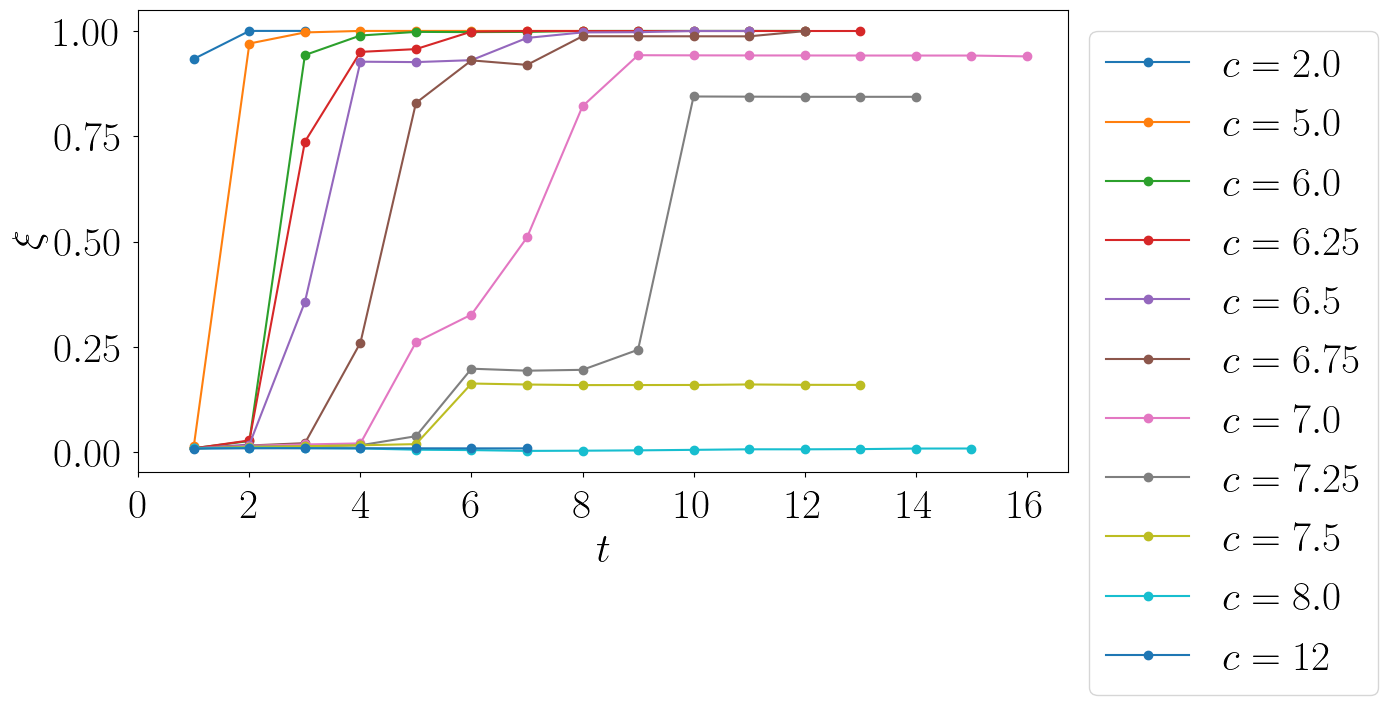

In [94]:
plt.figure(figsize=(12, 6))
for kbar, xi in xi_curves.items():
    # plt.semilogy(range(1, len(xi) + 1), xi, 'o-', label=fr'$c = {kbar}$')
    # plt.loglog(range(1, len(xi) + 1), xi, 'o-', label=fr'$c = {kbar}$')
    plt.plot(range(1, len(xi) + 1), xi, 'o-', label=fr'$c = {kbar}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\xi$')
plt.xticks(range(0, len(max(xi_curves.values(), key=len)) + 1, 2));
plt.legend(bbox_to_anchor=(1, 1));

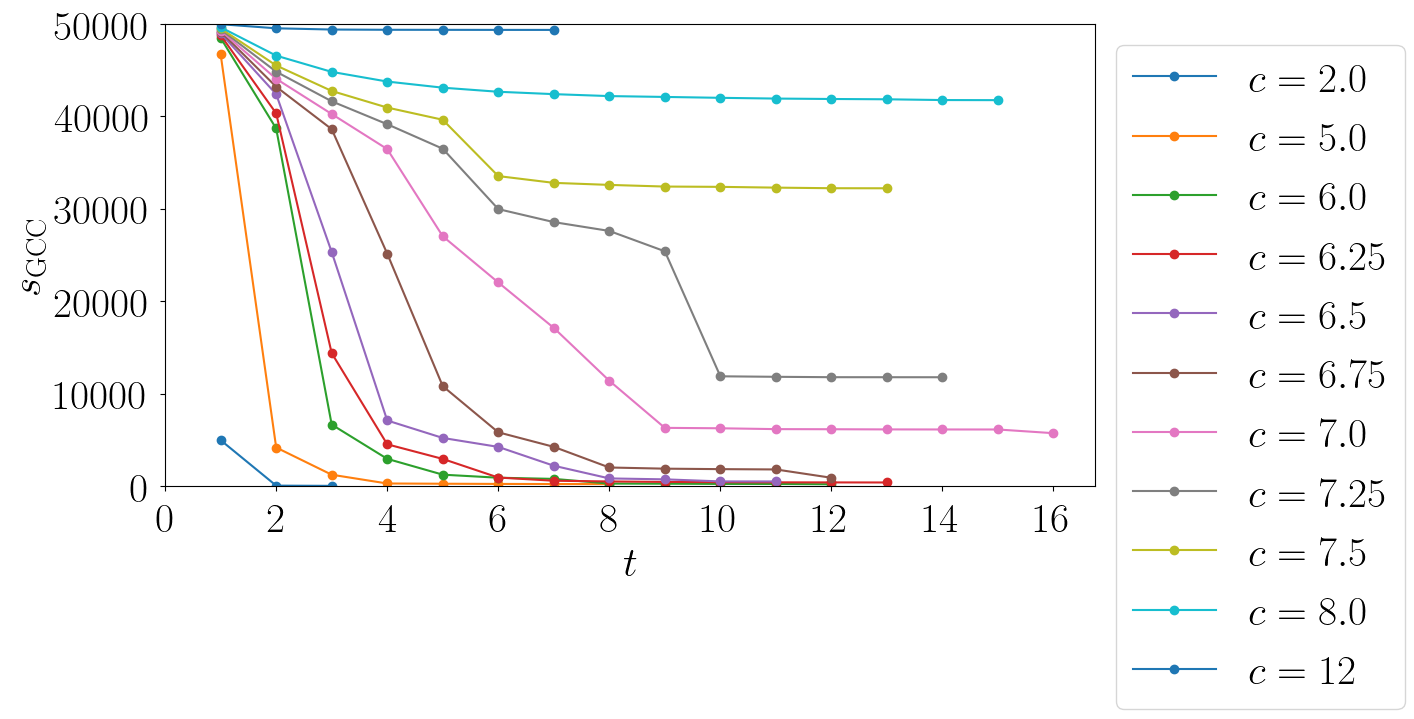

In [112]:
plt.figure(figsize=(12, 6))
for kbar, gcc_lens in gcc_stats.items():
    plt.plot(range(1, len(gcc_lens) + 1), gcc_lens, 'o-', label=fr'$c = {kbar}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$s_\mathrm{GCC}$')
plt.xticks(range(0, len(max(gcc_stats.values(), key=len)) + 1, 2))
# plt.yticks([1, 10, 100, 1000, 10000, 100000])
plt.ylim(0, 50000)
plt.legend(bbox_to_anchor=(1, 1));

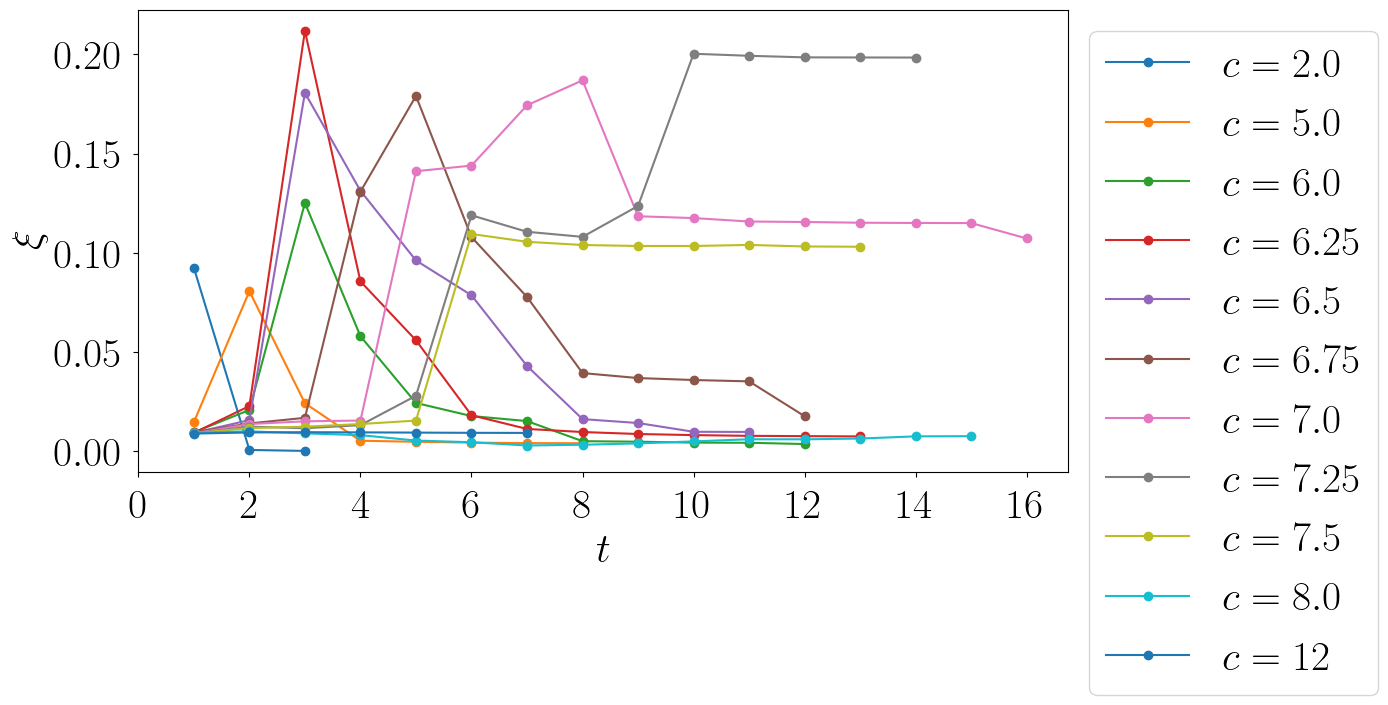

In [109]:
plt.figure(figsize=(12, 6))
for kbar in kbars:
    xi, gcc_lens = xi_curves[kbar], gcc_stats[kbar]
    plt.plot(
        range(1, len(xi) + 1),
        np.array(xi) * gcc_lens / N,
        'o-',
        label=fr'$c = {kbar}$',
    )
    # plt.loglog(range(1, len(xi) + 1), xi, 'o-', label=fr'$c = {kbar}$')
    # plt.text(0, xi[0], fr'$c = {kbar}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\xi$')
plt.xticks(range(0, len(max(xi_curves.values(), key=len)) + 1, 2));
plt.legend(bbox_to_anchor=(1, 1));